In [234]:
import pandas as pd
import numpy as np

In [ ]:
companies_selected = pd.read_excel("Companies.xlsx")

In [236]:
companies_selected.shape

(79, 5)

In [237]:
companies_selected.head()

,Company Name,Industry,Beta Value,Grade,TSR
0,NextEra Energy (NEE),Utilities,0.49,B,53.47
1,Duke Energy (DUK),Utilities,0.38,C,57.51
2,Atmos Energy (ATO),Utilities,0.50,B,54.13
3,Avangrid (AGR),Utilities,0.34,A,-8.57
4,Otter Tail (OTTR),Utilities,0.69,A,87.72


In [238]:
# since TSR is in % we will grade wight in % as well
grade_weight = {"A": 90, "B": 80, "C": 70, "D": 60, "E": 50, "F": 40}
companies_selected["GradeWeight"] = companies_selected["Grade"].map(grade_weight)

In [239]:
def calculate_grade_score(data, x):
    return (1 - x) * data["TSR"] + x * data["GradeWeight"]

In [240]:
def monte_carlo_simulation(
    data, max_industry_allocation=0.16, max_stock_allocation=0.045, target_beta=1.0
):
    best_portfolio = None
    best_portfolio_beta = float("inf")
    best_run = None

    for iteration in range(
        65000, 80000
    ):  # We want to keep the grade wight at a minumum of 0.65 of the total caluclation
        weight_factor = iteration / 100000  # Fraction for Grade Score calculation

        # Normalize TSR:
        data["Industry TSR total"] = data.groupby("Industry")["TSR"].transform("sum")
        data["Weighted TSR"] = data["TSR"] / data["Industry TSR total"]

        # Calculate Grade Score:
        data["Grade Score"] = data.apply(
            calculate_grade_score, axis=1, args=(weight_factor,)
        )

        # Calculate Weight:
        data["Weight"] = data["Grade Score"] / data["Grade Score"].sum()

        # Apply industry-level restrictions:
        data["Industry Allocation"] = data.groupby("Industry")["Weight"].transform(
            "sum"
        )
        data["Allocation_by_restriction"] = np.where(
            data["Industry Allocation"] > max_industry_allocation,
            max_industry_allocation,
            data["Industry Allocation"],
        )

        # Normalize Weights based on restrictions:
        data["Normalised Weight"] = np.where(
            data["Allocation_by_restriction"] == max_industry_allocation,
            (data["Weight"] / data["Industry Allocation"]) * max_industry_allocation,
            data["Weight"],
        )

        # Calculate Portfolio Beta:
        portfolio_beta = (data["Beta Value"] * data["Normalised Weight"]).sum()

        # Check if this portfolio is better:
        if portfolio_beta < best_portfolio_beta:
            test = weight_factor
            best_portfolio_beta = portfolio_beta
            best_run = iteration
            best_portfolio = data.copy()
            print(best_run, best_portfolio_beta)

    return test, best_run, best_portfolio_beta, best_portfolio

In [241]:
# def monte_carlo_simulation(
#     data, max_industry_allocation=0.16, max_stock_allocation=0.045, target_beta=1.0
# ):
#     best_portfolio = None
#     best_portfolio_beta = float("inf")
#     best_run = None

#     for iteration in range(
#         65000, 80000
#     ):  # We want to keep the grade wight at a minumum of 0.65 of the total caluclation
#         weight_factor = iteration / 100000  # Fraction for Grade Score calculation

#         # Normalize TSR:
#         data["Industry TSR total"] = data.groupby("Industry")["TSR"].transform("sum")
#         data["Weighted TSR"] = data["TSR"] / data["Industry TSR total"]

#         # Calculate Grade Score:
#         data["Grade Score"] = data.apply(
#             calculate_grade_score, axis=1, args=(weight_factor,)
#         )

#         # Calculate Weight:
#         data["Weight"] = data["Grade Score"] / data["Grade Score"].sum()

#         # Apply industry-level restrictions:
#         data["Industry Allocation"] = data.groupby("Industry")["Weight"].transform(
#             "sum"
#         )
#         data["Allocation_by_restriction"] = np.where(
#             data["Industry Allocation"] > max_industry_allocation,
#             max_industry_allocation,
#             data["Industry Allocation"],
#         )

#         # Normalize Weights based on restrictions:
#         data["Normalised Weight"] = np.where(
#             data["Allocation_by_restriction"] == max_industry_allocation,
#             (data["Weight"] / data["Industry Allocation"]) * max_industry_allocation,
#             data["Weight"],
#         )

#         # ------------------------------------------------------------------------stock level restriction
#         # data["stock_Allocation_by_restriction"] = np.where(
#         #     data["Normalised Weight"] > max_stock_allocation,
#         #     max_stock_allocation,
#         #     data["Normalised Weight"],
#         # )

#         # data["Normalised Weight"] = np.where(
#         #     data["Allocation_by_restriction"] == max_industry_allocation,
#         #     (data["Weight"] / data["Industry Allocation"]) * max_industry_allocation,
#         #     data["Weight"],
#         # )
#         # ------------------------------------------------------------------------stock level restriction
#         # Calculate Portfolio Beta:
#         portfolio_beta = (data["Beta Value"] * data["Normalised Weight"]).sum()

#         # Check if this portfolio is better:
#         if portfolio_beta < best_portfolio_beta:
#             test = weight_factor
#             best_portfolio_beta = portfolio_beta
#             best_run = iteration
#             best_portfolio = data.copy()
#             print(best_run, best_portfolio_beta)

#     return test, best_run, best_portfolio_beta, best_portfolio

In [242]:
test, run_no, final_beta, ideal_portfolio = monte_carlo_simulation(companies_selected)
print(f"best run: {run_no} final_beta: {final_beta} ")
print(ideal_portfolio)

65000 0.8796795000604941
best run: 65000 final_beta: 0.8796795000604941 
                                Company Name          Industry  Beta Value  \
0                       NextEra Energy (NEE)         Utilities        0.49   
1                          Duke Energy (DUK)         Utilities        0.38   
2                         Atmos Energy (ATO)         Utilities        0.50   
3                             Avangrid (AGR)         Utilities        0.34   
4                          Otter Tail (OTTR)         Utilities        0.69   
..                                       ...               ...         ...   
74  COSTCO WHOLESALE CORPORATION (XNAS:COST)  Consumer Staples        0.79   
75      DOLLAR GENERAL CORPORATION (XNYS:DG)  Consumer Staples        0.45   
76       COLGATE-PALMOLIVE COMPANY (XNYS:CL)  Consumer Staples        0.41   
77            THE HERSHEY COMPANY (XNYS:HSY)  Consumer Staples        0.37   
78                    UNILEVER PLC (XBUE:UL)  Consumer Staples       

In [243]:
ideal_portfolio

,Company Name,Industry,Beta Value,Grade,TSR,GradeWeight,Industry TSR total,Weighted TSR,Grade Score,Weight,Industry Allocation,Allocation_by_restriction,Normalised Weight
0,NextEra Energy (NEE),Utilities,0.49,B,53.47,80,358.64,0.149091,70.7145,0.009452,0.087150,0.087150,0.009452
1,Duke Energy (DUK),Utilities,0.38,C,57.51,70,358.64,0.160356,65.6285,0.008772,0.087150,0.087150,0.008772
2,Atmos Energy (ATO),Utilities,0.50,B,54.13,80,358.64,0.150931,70.9455,0.009483,0.087150,0.087150,0.009483
3,Avangrid (AGR),Utilities,0.34,A,-8.57,90,358.64,-0.023896,55.5005,0.007418,0.087150,0.087150,0.007418
4,Otter Tail (OTTR),Utilities,0.69,A,87.72,90,358.64,0.244591,89.2020,0.011923,0.087150,0.087150,0.011923
...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,COSTCO WHOLESALE CORPORATION (XNAS:COST),Consumer Staples,0.79,D,17.43,60,177.69,0.098092,45.1005,0.006028,0.077816,0.077816,0.006028
75,DOLLAR GENERAL CORPORATION (XNYS:DG),Consumer Staples,0.45,B,14.09,80,177.69,0.079295,56.9315,0.007609,0.077816,0.077816,0.007609
76,COLGATE-PALMOLIVE COMPANY (XNYS:CL),Consumer Staples,0.41,A,15.40,90,177.69,0.086668,63.8900,0.008540,0.077816,0.077816,0.008540
77,THE HERSHEY COMPANY (XNYS:HSY),Consumer Staples,0.37,B,12.95,80,177.69,0.072880,56.5325,0.007556,0.077816,0.077816,0.007556


In [244]:
ideal_portfolio["Normalised Weight"].sum()

0.871516904975013

In [245]:
ideal_portfolio["final_weight"] = (
    ideal_portfolio["Normalised Weight"] / ideal_portfolio["Normalised Weight"].sum()
) * 100

In [246]:
round(ideal_portfolio["final_weight"].sum(), 2) == 100.00

True

In [247]:
ideal_portfolio.sort_values(by="final_weight", ascending=False)

,Company Name,Industry,Beta Value,Grade,TSR,GradeWeight,Industry TSR total,Weighted TSR,Grade Score,Weight,Industry Allocation,Allocation_by_restriction,Normalised Weight,final_weight
44,NVDA,Technology,1.76,C,2694.86,70,4829.52,0.557997,988.7010,0.132150,0.288483,0.160000,0.073294,8.409901
25,Eli Lilly and Company (LLY),Healthcare,0.42,C,675.16,70,1435.04,0.470482,281.8060,0.037666,0.136636,0.136636,0.037666,4.321918
40,TSLA,Technology,2.12,A,1236.11,90,4829.52,0.255949,491.1385,0.065646,0.288483,0.160000,0.036409,4.177629
10,Interactive Brokers (IBKR),Finance,0.79,D,303.51,60,1525.19,0.198998,145.2285,0.019411,0.139116,0.139116,0.019411,2.227297
11,LPL Financial (LPLA),Finance,0.85,C,276.95,70,1525.19,0.181584,142.4325,0.019038,0.139116,0.139116,0.019038,2.184416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,"Hitachi, Ltd. (OTCM:HTHIY)",Industruals,1.15,D,8.50,60,125.13,0.067929,41.9750,0.005610,0.069275,0.069275,0.005610,0.643750
61,"UNITED PARCEL SERVICE, INC. (XNYS:UPS)",Industruals,0.98,D,6.04,60,125.13,0.048270,41.1140,0.005495,0.069275,0.069275,0.005495,0.630545
64,Siemens AG (XBUE:SIEGY),Industruals,1.22,E,8.50,50,125.13,0.067929,35.4750,0.004742,0.069275,0.069275,0.004742,0.544062
48,COIN,Technology,3.34,B,-10.57,80,4829.52,-0.002189,48.3005,0.006456,0.288483,0.160000,0.003581,0.410845


In [249]:
# ---------------------------------------------------------------------- EVERYTHING BELOW IS FOR TESTING OUT PORTFOLIO (WIP CURRENTLY)

In [315]:
final_port = ideal_portfolio[["Company Name", "final_weight"]]
ticker_map = pd.read_excel("ticker_map.xlsx")
mapping_dict = dict(zip(ticker_map["Company Name"], ticker_map["Ticker"]))
# final_port = final_port.copy()
final_port["Ticker"] = final_port["Company Name"].map(mapping_dict)

C:\Users\asus\AppData\Local\Temp\ipykernel_25280\395006773.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_port["Ticker"] = final_port["Company Name"].map(mapping_dict)


In [316]:
final_port = final_port.set_index("Ticker")
final_port

,Company Name,final_weight
Ticker,,
NEE,NextEra Energy (NEE),1.084513
DUK,Duke Energy (DUK),1.006512
ATO,Atmos Energy (ATO),1.088056
AGR,Avangrid (AGR),0.851184
OTTR,Otter Tail (OTTR),1.368047
...,...,...
COST,COSTCO WHOLESALE CORPORATION (XNAS:COST),0.691684
DG,DOLLAR GENERAL CORPORATION (XNYS:DG),0.873130
CLX,COLGATE-PALMOLIVE COMPANY (XNYS:CL),0.979849


In [362]:
start_date = "2023-01-01"

# Generate the start of each month for the next 10 months
month_starts = pd.date_range(
    start=start_date, periods=12, freq="MS"
)  # 'MS' = Month Start

# Create a DataFrame with 10 empty columns (NaN values)
new_columns = pd.DataFrame(
    np.nan, index=final_port.index, columns=month_starts.strftime("%Y-%m-%d")
)

# Concatenate the existing DataFrame with the new columns
df_updated = pd.concat([final_port, new_columns], axis=1)
df_updated

,Company Name,final_weight,2023-01-01,2023-02-01,2023-03-01,2023-04-01,2023-05-01,2023-06-01,2023-07-01,2023-08-01,2023-09-01,2023-10-01,2023-11-01,2023-12-01
Ticker,,,,,,,,,,,,,,
NEE,NextEra Energy (NEE),1.084513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DUK,Duke Energy (DUK),1.006512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ATO,Atmos Energy (ATO),1.088056,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AGR,Avangrid (AGR),0.851184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OTTR,Otter Tail (OTTR),1.368047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
COST,COSTCO WHOLESALE CORPORATION (XNAS:COST),0.691684,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DG,DOLLAR GENERAL CORPORATION (XNYS:DG),0.873130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CLX,COLGATE-PALMOLIVE COMPANY (XNYS:CL),0.979849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [363]:
### USE THISS

import yfinance as yf
from datetime import datetime


def get_returns(ticker, checkdate):
    # Calculate the start of the year for the given date
    try:
        start_of_year = datetime(checkdate.year, 1, 1)

        # Fetch data using yfinance
        data = yf.download(ticker, start=start_of_year, end=checkdate, interval="1mo")

        # Get the adjusted close price on the first day of the year
        start_price = data["Adj Close"].iloc[0]  # Price on the start of the year

        # Calculate the return as the percentage change from the start of the year
        current_price = data["Adj Close"].iloc[-1]  # Price on the current date

        pct_change = ((current_price / start_price) - 1) * 100  # Percentage change

        return pct_change

    except Exception as e:
        # Catch the specific error for failed downloads
        print(f"Failed to download data for {ticker}: {e}")
        return None


for indx in df_updated.index:
    for months in df_updated.columns[3:]:  # Skip the first column (e.g., Jan)
        # Ensure `months` is handled as a datetime object
        if isinstance(months, str):
            month = datetime.strptime(months, "%Y-%m-%d")
        else:
            month = months  # Already a datetime object

        # Update your DataFrame with the calculated return
        if indx == "PKST":
            break
        else:
            df_updated.at[indx, months] = get_returns(indx, month).values[0]

df_updated

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

,Company Name,final_weight,2023-01-01,2023-02-01,2023-03-01,2023-04-01,2023-05-01,2023-06-01,2023-07-01,2023-08-01,2023-09-01,2023-10-01,2023-11-01,2023-12-01
Ticker,,,,,,,,,,,,,,
NEE,NextEra Energy (NEE),1.084513,NaN,0.0,-4.823799,3.950020,3.343147,-0.931924,0.708246,-0.513257,-9.335436,-21.704216,-20.323893,-20.036885
DUK,Duke Energy (DUK),1.006512,NaN,0.0,-7.994139,-4.873841,-2.497420,-11.953829,-10.603866,-6.738720,-11.540263,-11.084317,-10.449640,-7.034451
ATO,Atmos Energy (ATO),1.088056,NaN,0.0,-4.024166,-3.798086,-2.274054,-1.298014,0.248475,4.875732,-0.087590,-8.139075,-6.638847,-1.305648
AGR,Avangrid (AGR),0.851184,NaN,0.0,-7.446044,-4.377499,-3.466362,-10.012227,-8.571140,-10.027012,-16.287273,-25.865019,-26.602203,-24.144959
OTTR,Otter Tail (OTTR),1.368047,NaN,0.0,10.506628,13.434024,12.931746,16.479007,24.636779,27.872665,30.019383,20.412719,22.030491,21.031268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
COST,COSTCO WHOLESALE CORPORATION (XNAS:COST),0.691684,NaN,0.0,-5.274491,-2.622579,-1.378097,0.256393,5.732695,10.110228,7.873356,11.162398,8.698930,16.628414
DG,DOLLAR GENERAL CORPORATION (XNYS:DG),0.873130,NaN,0.0,-7.405821,-9.905824,-5.196918,-13.677215,-27.117792,-27.512716,-40.337616,-54.423966,-48.720504,-43.201730
CLX,COLGATE-PALMOLIVE COMPANY (XNYS:CL),0.979849,NaN,0.0,8.324421,10.275695,15.418728,11.026814,11.630474,6.324101,9.812548,-7.329588,-16.776226,2.367450


In [364]:
df_updated

,Company Name,final_weight,2023-01-01,2023-02-01,2023-03-01,2023-04-01,2023-05-01,2023-06-01,2023-07-01,2023-08-01,2023-09-01,2023-10-01,2023-11-01,2023-12-01
Ticker,,,,,,,,,,,,,,
NEE,NextEra Energy (NEE),1.084513,NaN,0.0,-4.823799,3.950020,3.343147,-0.931924,0.708246,-0.513257,-9.335436,-21.704216,-20.323893,-20.036885
DUK,Duke Energy (DUK),1.006512,NaN,0.0,-7.994139,-4.873841,-2.497420,-11.953829,-10.603866,-6.738720,-11.540263,-11.084317,-10.449640,-7.034451
ATO,Atmos Energy (ATO),1.088056,NaN,0.0,-4.024166,-3.798086,-2.274054,-1.298014,0.248475,4.875732,-0.087590,-8.139075,-6.638847,-1.305648
AGR,Avangrid (AGR),0.851184,NaN,0.0,-7.446044,-4.377499,-3.466362,-10.012227,-8.571140,-10.027012,-16.287273,-25.865019,-26.602203,-24.144959
OTTR,Otter Tail (OTTR),1.368047,NaN,0.0,10.506628,13.434024,12.931746,16.479007,24.636779,27.872665,30.019383,20.412719,22.030491,21.031268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
COST,COSTCO WHOLESALE CORPORATION (XNAS:COST),0.691684,NaN,0.0,-5.274491,-2.622579,-1.378097,0.256393,5.732695,10.110228,7.873356,11.162398,8.698930,16.628414
DG,DOLLAR GENERAL CORPORATION (XNYS:DG),0.873130,NaN,0.0,-7.405821,-9.905824,-5.196918,-13.677215,-27.117792,-27.512716,-40.337616,-54.423966,-48.720504,-43.201730
CLX,COLGATE-PALMOLIVE COMPANY (XNYS:CL),0.979849,NaN,0.0,8.324421,10.275695,15.418728,11.026814,11.630474,6.324101,9.812548,-7.329588,-16.776226,2.367450


In [382]:
data = yf.download("SPY", start="2023-01-01", end="2023-06-01", interval="1mo")
# Get the adjusted close price on the first day of the year
start_price = data["Adj Close"].iloc[0]  # Price on the start of the year

# Calculate the return as the percentage change from the start of the year
current_price = data["Adj Close"].iloc[-1]  # Price on the current date

pct_change = ((current_price / start_price) - 1) * 100  # Percentage change

pct_change.values[0]

[*********************100%***********************]  1 of 1 completed


3.1895053565421883

ValueError: x and y must have same first dimension, but have shapes (12,) and (0, 14)

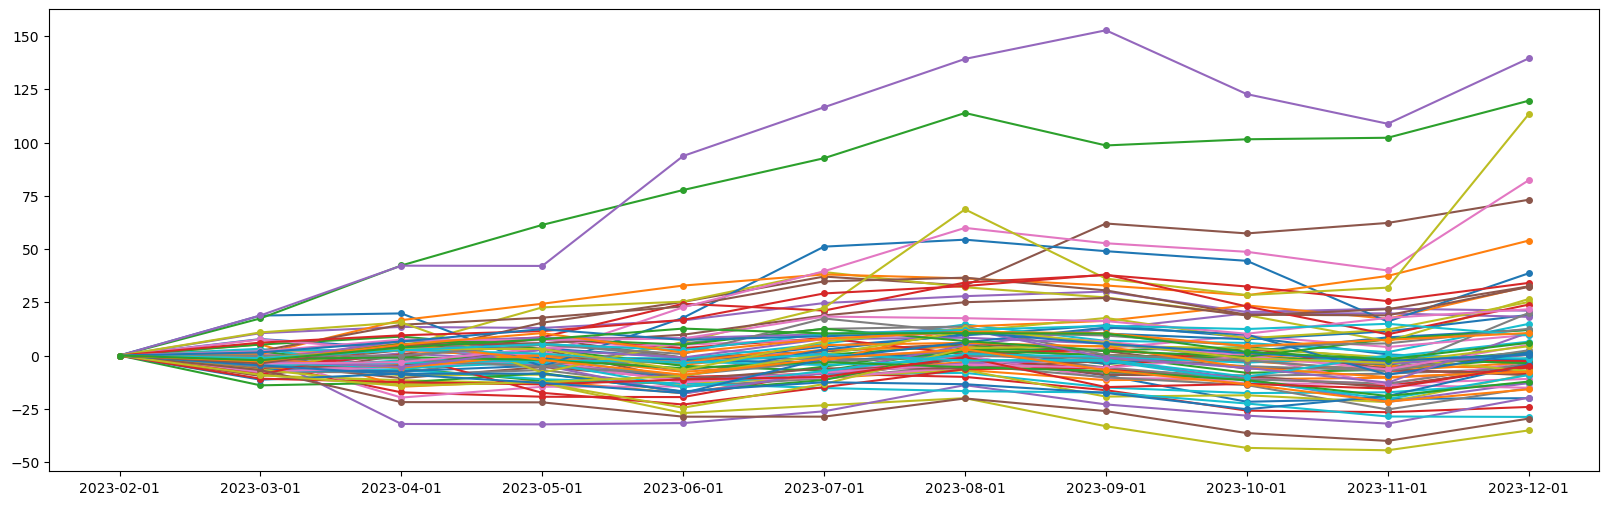

In [370]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))
for ticker in df_updated.index:
    # Select the data from the 3rd column onward
    plt.plot(
        df_updated.columns[2:],
        df_updated.loc[ticker].values[2:],
        label=ticker,
        marker="o",
        markersize=4,
    )

plt.legend(title="Ticker")
plt.show()

In [372]:
for col in df_updated.columns[2:]:
    df_updated[col] = df_updated[col] * (df_updated["final_weight"] / 100)
df_updated

,Company Name,final_weight,2023-01-01,2023-02-01,2023-03-01,2023-04-01,2023-05-01,2023-06-01,2023-07-01,2023-08-01,2023-09-01,2023-10-01,2023-11-01,2023-12-01
Ticker,,,,,,,,,,,,,,
NEE,NextEra Energy (NEE),1.084513,NaN,0.0,-0.056736,0.046459,0.039321,-0.010961,0.008330,-0.006037,-0.109800,-0.255278,-0.239043,-0.235668
DUK,Duke Energy (DUK),1.006512,NaN,0.0,-0.080986,-0.049375,-0.025301,-0.121100,-0.107424,-0.068268,-0.116910,-0.112291,-0.105862,-0.071264
ATO,Atmos Energy (ATO),1.088056,NaN,0.0,-0.047641,-0.044964,-0.026922,-0.015367,0.002942,0.057722,-0.001037,-0.096356,-0.078595,-0.015457
AGR,Avangrid (AGR),0.851184,NaN,0.0,-0.053948,-0.031716,-0.025114,-0.072540,-0.062099,-0.072647,-0.118003,-0.187396,-0.192737,-0.174933
OTTR,Otter Tail (OTTR),1.368047,NaN,0.0,0.196637,0.251425,0.242024,0.308413,0.461090,0.521651,0.561828,0.382035,0.412312,0.393611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
COST,COSTCO WHOLESALE CORPORATION (XNAS:COST),0.691684,NaN,0.0,-0.025235,-0.012547,-0.006593,0.001227,0.027427,0.048370,0.037668,0.053404,0.041618,0.079555
DG,DOLLAR GENERAL CORPORATION (XNYS:DG),0.873130,NaN,0.0,-0.056459,-0.075518,-0.039619,-0.104269,-0.206734,-0.209745,-0.307516,-0.414904,-0.371424,-0.329351
CLX,COLGATE-PALMOLIVE COMPANY (XNYS:CL),0.979849,NaN,0.0,0.079923,0.098657,0.148036,0.105869,0.111665,0.060718,0.094211,-0.070372,-0.161069,0.022730


In [ ]:
# Sum the values of each column (from the 3rd column onward)
column_sums = df_updated.iloc[:, 2:].sum(axis=0)

# Create a new DataFrame with the same columns
df_sums = pd.DataFrame(
    column_sums
).T  # Transpose to match the structure of the original DataFrame
df_sums.columns = df_updated.columns[
    2:
]  # Assign the column names from the 3rd column onward

# Add the two new index values: 'portfolio name' and 'SPY'
df_sums.index = ["portfolio"]
spy_values = []

# Iterate over the columns from the 3rd column onward
for months in df_updated.columns[2:]:
    if isinstance(months, str):
        month = datetime.strptime(months, "%Y-%m-%d")
    else:
        month = months  # Already a datetime object
    spy_value = get_returns("SPY", month).value[0]
    spy_values.append(spy_value)
df_sums.loc["SPY"] = spy_values
df_sums

[*********************100%***********************]  1 of 1 completed

Failed to download data for SPY: single positional indexer is out-of-bounds


AttributeError: 'NoneType' object has no attribute 'values'